<a href="https://colab.research.google.com/github/arminarj/convex-optimization-boyd/blob/master/Flux_balance_analysis_in_systems_biology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install cvxpy==1.1.0a4 -q
!pip install diffcp -q

     |████████████████████████████████| 993kB 3.1MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.2MB 3.3MB/s 


# Flux balance analysis in systems biology.

importing question datas

In [0]:
# data file for flux balance analysis in systems biology
# From Segre, Zucker et al "From annotated genomes to metabolic flux
# models and kinetic parameter fitting" OMICS 7 (3), 301-316. 
import numpy as np

# Stoichiometric matrix
S = np.array([
#	M1	M2	M3	M4	M5	M6	
	[1,	0,	0,	0,	0,	0],	#	R1:  extracellular -->  M1
	[-1,	1,	0,	0,	0,	0],	#	R2:  M1 -->  M2
	[-1,	0,	1,	0,	0,	0],	#	R3:  M1 -->  M3
	[0,	-1,	0,	2,	-1,	0],	#	R4:  M2 + M5 --> 2 M4
	[0,	0,	0,	0,	1,	0],	#	R5:  extracellular -->  M5
	[0,	-2,	1,	0,	0,	1],	#	R6:  2 M2 -->  M3 + M6
	[0,	0,	-1,	1,	0,	0],	#	R7:  M3 -->  M4
	[0,	0,	0,	0,	0,	-1],	#	R8:  M6 --> extracellular
	[0,	0,	0,	-1,	0,	0],	#	R9:  M4 --> cell biomass
	]).T

m, n = S.shape
vmax = np.array([
	10.10,	# R1:  extracellular -->  M1
	100,	# R2:  M1 -->  M2
	5.90,	# R3:  M1 -->  M3
	100,	# R4:  M2 + M5 --> 2 M4
	3.70,	# R5:  extracellular -->  M5
	100,	# R6:  2 M2 --> M3 + M6
	100,	# R7:  M3 -->  M4
	100,	# R8:  M6 -->  extracellular
	100,	# R9:  M4 -->  cell biomass
	])

Defining problom with DCP structure.


In [65]:
import cvxpy as cp

V = cp.Variable(n)

obj = cp.Maximize(V[-1])
constraints  = [
                0 <= V,
                V <= vmax,
                S@V == 0,
]

prob = cp.Problem(obj, constraints)

print("prob is DCP:", prob.is_dcp())

try:
    prob.solve(requires_grad=True)
    print("status:  ", prob.status)
    print("optimal value:  ", prob.value)
except Exception as e:
    print(e)


prob is DCP: True
status:   optimal
optimal value:   13.55005752337796


Sensivity:

In [19]:
dV = np.ones(n)*1e-2 ; dV[-1] = 0;

V.delta = dV

prob.derivative()

G = V[-1]

V.value += dV

G_hat = V[-1].value

prob.solve()
print('G: predicted {0:.5f} actual {1:.5f}'.format(G_hat, G.value))

V.value -= dV

G: predicted 13.55006 actual 13.55000


Part B:

In [75]:
G_min = 0.2 * G.value 
G_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):

        V = cp.Variable(n)

        obj = cp.Maximize(V[-1])

        constraints  = [
                        0 <= V,
                        V <= vmax,
                        S@V == 0,
                        V[i] == 0, 
                        V[j] == 0,
        ]

        prob = cp.Problem(obj, constraints)
        try:
            prob.solve()
            G_matrix[i, j] = G_matrix[j, i] = prob.value
        except Exception as e:
            print(e)

G_matrix = G_matrix < G_min
print(G_matrix)

[[ True  True  True  True  True  True  True  True  True]
 [ True False  True False False False  True False  True]
 [ True  True False False False False False False  True]
 [ True False False False False False  True False  True]
 [ True False False False False False  True False  True]
 [ True False False False False False False False  True]
 [ True  True False  True  True False False False  True]
 [ True False False False False False False False  True]
 [ True  True  True  True  True  True  True  True  True]]


### plotting sensevity:

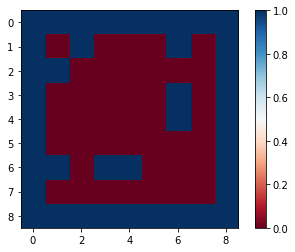

In [89]:
import matplotlib.pyplot as plt

plt.imshow(G_matrix, cmap='RdBu')
plt.title('')
plt.colorbar()
plt.show()

It seems the first and last Metabolites are essential.
additionally, there is other coupled essential metablites too.